In [1]:
import importlib
import MPI_collective
import MPI
import qiskit
import math
from qiskit import QuantumCircuit, transpile, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
importlib.reload(MPI_collective)
importlib.reload(MPI)

<module 'MPI' from '/workspaces/qmpi_cpe_kmutt/QMPI_Tinthai_Version/playground/MPI.py'>

In [2]:
# Requirement
# !pip install qiskit
# !pip install pylatexenc
# !pip install qiskit-aer

In [9]:
# Function พวกนี้ เราเขียนมาเพื่อให้ใช้งานง่ายขึ้นเฉยๆนะ

def qdata_to_circuit(qc, qdata):
    # for inst, qargs, cargs in qdata:
    #     qc.append(inst, qargs, cargs)
    for instr in qdata:
        qc.append(instr.operation, instr.qubits, instr.clbits)

def beautifule_print_result(qc, counts):
    creg_sequence = []
    for creg in qc.cregs:
        creg_sequence.append(f"{creg.name}[{creg.size}]")
    creg_sequence.reverse()
    print("Classical registers (left→right):", " → ".join(creg_sequence))

    print("\nCounts:")
    for bits, count in counts.items():
        print(f"{bits} : {count}")

def prob_single_cbit(counts, target_index):
    # index ของ cbit ตรงกลาง (จากซ้ายไปขวา)
    total = sum(counts.values())

    p0 = sum(v for k, v in counts.items() if k.split()[target_index] == '0') / total
    p1 = sum(v for k, v in counts.items() if k.split()[target_index] == '1') / total

    print(f"P(cbit[{target_index}] = 0) = {p0:.4f}")
    print(f"P(cbit[{target_index}] = 1) = {p1:.4f}")

In [10]:
# สร้าง Quantum circuit โดยเตรียมพวก Quantum register,  Classical register เอาไว้ใช้
sendqc_circuit = QuantumCircuit()
node1 = QuantumRegister(1, name = "node1")
node1_epr = QuantumRegister(2, name = "node1_epr")
node1_epr_creg = ClassicalRegister(1, name = "node1_epr_creg")
node2 = QuantumRegister(1, name = "node2")
node2_epr = QuantumRegister(2, name = "node2_epr")
node2_epr_creg = ClassicalRegister(1, name = "node2_epr_creg")
node3 = QuantumRegister(1, name = "node3")
node3_epr = QuantumRegister(1, name = "node3_epr")
node3_epr_creg = ClassicalRegister(1, name = "node3_epr_creg")
epr_c = ClassicalRegister(2, name = "epr_cr")
sendqc_circuit.add_register(node1,node1_epr,node2,node2_epr,node3,node3_epr)
sendqc_circuit.add_register(node1_epr_creg,node2_epr_creg,node3_epr_creg)
# sendqc_circuit.draw('mpl')

In [11]:
# Initiate ให้ node1[0] มีโอกาส ket(0) ~85%
sendqc_circuit.rx(math.pi/4, node1[0])   # หมุนแกน X มุม π/4 บน qubit 0
# ลองใช้ QMPI ของ Tom Nguyen ดู
sendqc_epr_class = MPI.EPRsetup(sendqc_circuit, node1[0], node2[0])

# Send 
operation = sendqc_epr_class.send()
qdata_to_circuit(sendqc_epr_class.q, operation)

# # Unsend
# operation = sendqc_epr_class.unsend()
# qdata_to_circuit(sendqc_epr_class.q, operation)

# การวัดด้วยตัวเอง
sendqc_epr_class.q.barrier()
sendqc_epr_class.recieveEPR(sendqc_epr_class.q, node1_epr[0], node1_epr_creg[0])
sendqc_epr_class.recieveEPR(sendqc_epr_class.q, node2_epr[0], node2_epr_creg[0])
sendqc_epr_class.recieveEPR(sendqc_epr_class.q, node3_epr[0], node3_epr_creg[0])

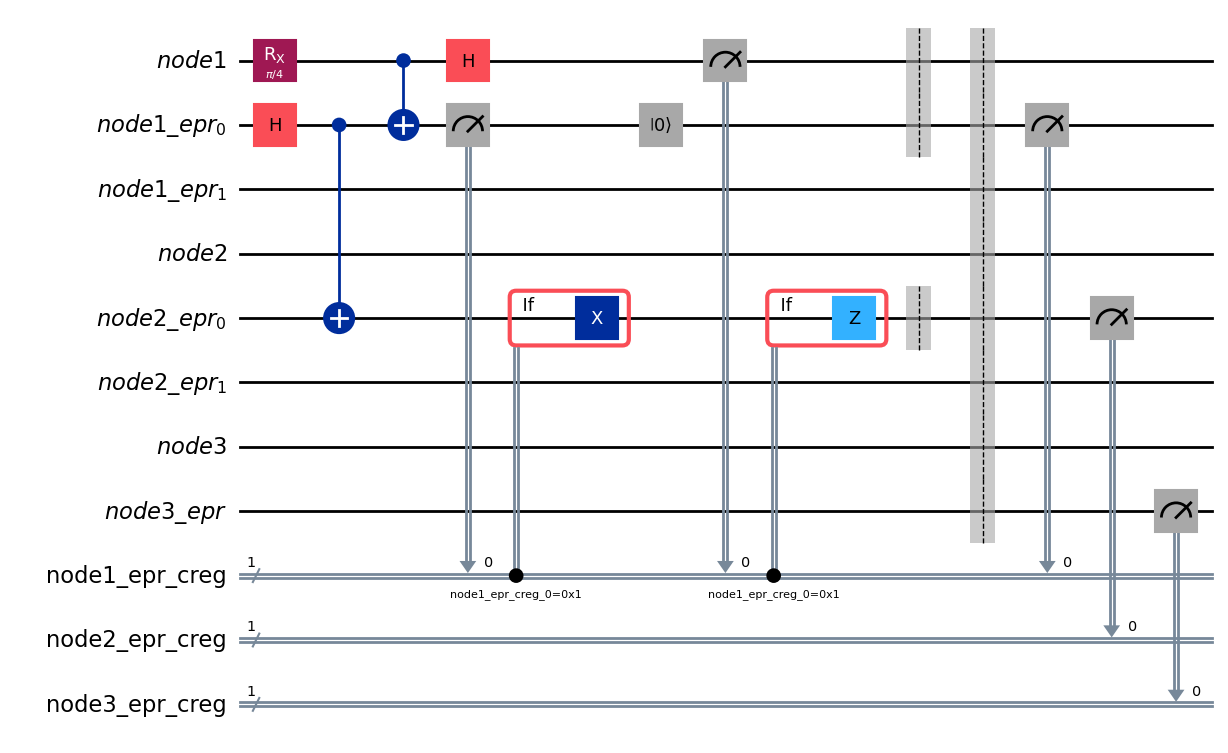

In [12]:
# # เผื่ออยากดูวงจร
sendqc_epr_class.q.draw('mpl')

In [13]:
sim = AerSimulator()
sendqc_ready2run = transpile(sendqc_epr_class.q, sim)
result = sim.run(sendqc_ready2run).result()
counts = result.get_counts()
beautifule_print_result(sendqc_epr_class.q, counts)
# print(counts)
## ถ้าใส่ add_register(c0,c1,c2) ผลลัพธ์จะเป็น 'c2, c1, c0'

prob_single_cbit(counts, target_index=1)

Classical registers (left→right): node3_epr_creg[1] → node2_epr_creg[1] → node1_epr_creg[1]

Counts:
0 1 0 : 159
0 0 0 : 865
P(cbit[1] = 0) = 0.8447
P(cbit[1] = 1) = 0.1553


In [8]:
# # build distributed circuit with N nodes and returns circuit with list of quantum registers
# def buildQMPI(N):
#     circ = QuantumCircuit() 
#     qrs = [] 
#     for i in range(N):
#         qr = QuantumRegister(1, name = 'q'+str(i))
#         circ.add_register(qr)
#         qrs.append(qr)
#     cr = ClassicalRegister(N,name = 'cr')
#     circ.add_register(cr)
#     return circ, qrs

# a,b = buildQMPI(4)

# This section is Collective Operation parts

In [87]:
collective_circuit = QuantumCircuit()
node1_coll = QuantumRegister(1, name = "node1")
node2_coll = QuantumRegister(1, name = "node2")
node3_coll = QuantumRegister(1, name = "node3")
node4_coll = QuantumRegister(1, name = "node4")
node5_coll = QuantumRegister(1, name = "node5")
collective_circuit.add_register(node1_coll,node2_coll,node3_coll,node4_coll,node5_coll)
# sendqc_circuit.add_register(node1_epr_creg,node2_epr_creg,node3_epr_creg)

In [88]:
# Initiate ให้ node1[0] มีโอกาส ket(0) ~85%
collective_circuit.rx(math.pi/4, node1[0])   # หมุนแกน X มุม π/4 บน qubit 0

collective_class = MPI_collective.CollectiveMPI(collective_circuit)
# collective_class.q.draw('mpl')
# print(collective_class.length)

# Broadcast 
operation = collective_class.brodcast([node1_coll[0], node2_coll[0], node3_coll[0], node4_coll[0], node4_coll[0], node5_coll[0]])
# qdata_to_circuit(collective_class.q, operation)

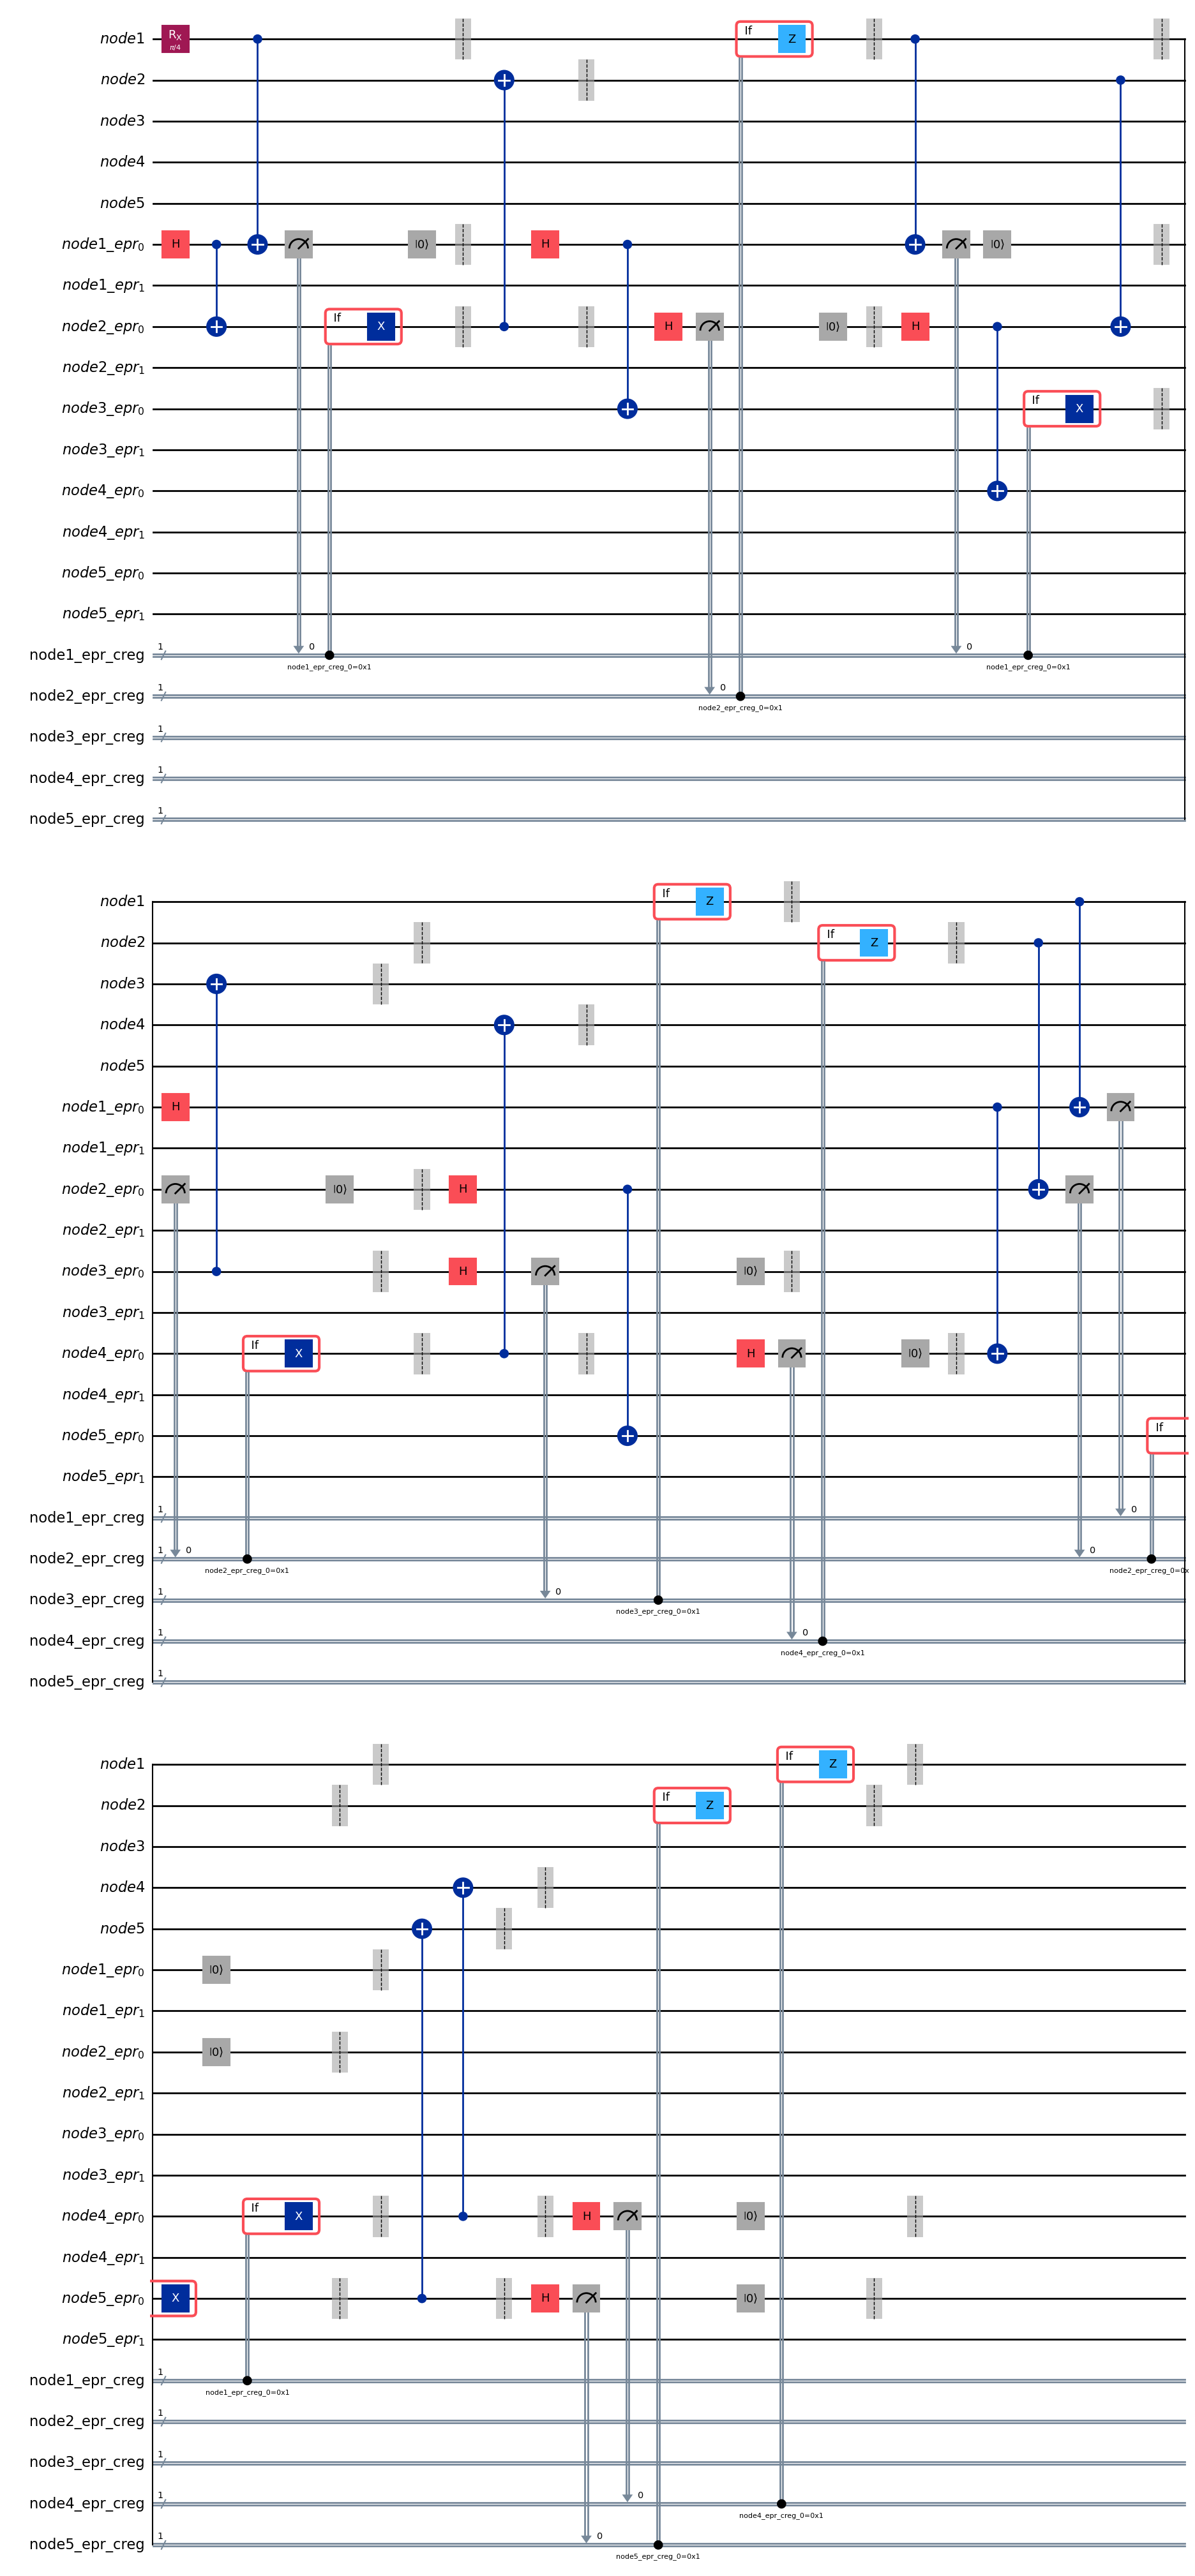

In [89]:
collective_class.q.draw('mpl')

In [91]:
sim = AerSimulator()
collective_ready2run = transpile(collective_class.q, sim)
result = sim.run(collective_ready2run).result()
counts = result.get_counts()
beautifule_print_result(collective_class.q, counts)
# print(counts)
## ถ้าใส่ add_register(c0,c1,c2) ผลลัพธ์จะเป็น 'c2, c1, c0'

prob_single_cbit(counts, target_index=0)

Classical registers (left→right): node5_epr_creg[1] → node4_epr_creg[1] → node3_epr_creg[1] → node2_epr_creg[1] → node1_epr_creg[1]

Counts:
1 1 0 1 0 : 27
0 1 1 0 1 : 36
0 0 1 1 1 : 30
0 1 1 1 0 : 34
1 1 0 0 0 : 43
1 0 0 0 0 : 26
1 1 1 1 1 : 27
1 1 0 1 1 : 41
1 1 1 0 0 : 40
1 0 1 0 1 : 27
1 0 0 1 0 : 47
0 1 1 1 1 : 30
1 1 1 1 0 : 40
0 1 1 0 0 : 32
0 1 0 0 0 : 35
0 0 0 0 1 : 20
0 0 1 1 0 : 23
0 1 0 0 1 : 26
1 0 0 0 1 : 31
0 0 1 0 1 : 32
0 1 0 1 1 : 39
1 1 1 0 1 : 28
0 0 0 1 1 : 35
0 0 1 0 0 : 28
0 1 0 1 0 : 35
1 0 1 1 1 : 33
1 0 1 0 0 : 33
1 0 0 1 1 : 26
1 0 1 1 0 : 31
0 0 0 1 0 : 26
0 0 0 0 0 : 30
1 1 0 0 1 : 33
P(cbit[0] = 0) = 0.4795
P(cbit[0] = 1) = 0.5205
